# Decision Tree Regressor from Scratch

In [1]:
from random import seed
from math import log
from statistics import mode
from random import randrange
from csv import reader
import numpy as np
import matplotlib.pyplot as plt

## Create dataset

In [2]:
dataset = [[2.771244718, 1.784783929, 0],
           [1.728571309, 1.169761413, 0.1],
           [3.678319846, 2.81281357, 0.2],
           [3.961043357, 2.61995032, -0.1],
           [2.999208922, 2.209014212, 0.3],
           [7.497545867, 3.162953546, 1.1],
           [9.00220326, 3.339047188, 1.2],
           [7.444542326, 0.476683375, 1.9],
           [10.12493903, 3.234550982, 0.9],
           [6.642287351, 3.319983761, 1.6]]

## Choose best splits using heuristic Funtion: Gini index and Cross-Entropy

In [3]:
def split_criteria(y, criteria = 'std'):
    """
    split_criteria([1,2,3,4,3], 'std') = std([1,2,3,4,3])
    """
    if criteria == 'std':
        if len(y) == 0: return 0
        return np.std(y)
    if criteria == 'mae':
        u = np.mean(y)
        return np.mean(np.abs(u - y))

group_targets = [[1,2,1],[1,1,2]]
s1, s2 = group_targets
print(split_criteria(s1, 'std'))
print(split_criteria(s1, 'mae'))

0.4714045207910317
0.4444444444444444


In [4]:
def test_split(index, value, dataset):
    """
    Split a dataset based on an attribute and an attribute value.
    Complexity: O(#rows)
    """
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [5]:
def get_split(dataset, criteria):
    """
    This heuristic algorithm loops all rows (samples) and column (attributes), thus it is painful for computing.
    Complexity: O(#rows^2 x #columns) x O(gini_index)
    """
    attributes = len(dataset[0]) - 1
    retAttribute, retValue, retGroups, min_loss = None, None, None, 999
    for row in dataset:
        for attribute in range(attributes):
            group_left, group_right = test_split(attribute, row[attribute], dataset)
#             group_left, group_right = groups
            target_left = [row[-1] for row in group_left]
            target_right = [row[-1] for row in group_right]

            total = len(target_left) + len(target_right)
            pL = len(target_left) / total
            
            loss =  pL * split_criteria(target_left, criteria) + (1 - pL) * split_criteria(target_right, criteria)
            if loss < min_loss:
                min_loss = loss
                retAttribute, retValue, retGroups = attribute, row[attribute], (group_left, group_right)
    return {'attribute': retAttribute, 'value': retValue, 'groups': retGroups}

get_split(dataset, 'std')


{'attribute': 0,
 'value': 6.642287351,
 'groups': ([[2.771244718, 1.784783929, 0],
   [1.728571309, 1.169761413, 0.1],
   [3.678319846, 2.81281357, 0.2],
   [3.961043357, 2.61995032, -0.1],
   [2.999208922, 2.209014212, 0.3]],
  [[7.497545867, 3.162953546, 1.1],
   [9.00220326, 3.339047188, 1.2],
   [7.444542326, 0.476683375, 1.9],
   [10.12493903, 3.234550982, 0.9],
   [6.642287351, 3.319983761, 1.6]])}

In [6]:
def to_terminal(group):
    assert group, 'group should not be empty'
    outcomes = [row[-1] for row in group]
    return np.mean(outcomes)  # most frequency
    
group = [[1, 2, 0], [1, 2, 1], [1, 2, 1]]
to_terminal(group)


0.6666666666666666

In [7]:
def split(node, max_depth, min_size, depth, criteria):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:  # left or right is empty list
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, criteria)
        split(node['left'], max_depth, min_size, depth+1, criteria)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, criteria)
        split(node['right'], max_depth, min_size, depth+1, criteria)


## Build a decision tree

In [8]:
# Build a decision tree
def build_tree(train_set, max_depth, min_size, criteria):
    root = get_split(train_set, criteria)
    split(root, max_depth, min_size, 0, criteria)
    return root

# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' %
              ((depth*'-', (node['attribute']+1), node['value'])))
        print_tree(node['left'], depth+2)
        print_tree(node['right'], depth+2)
    else:
        print('%s[%s]' % ((depth*'-', node)))  # This is cool!


tree = build_tree(dataset, 2, 1, 'std')
print_tree(tree)
# print(tree)

[X1 < 6.642]
--[X1 < 3.961]
----[X1 < 2.999]
------[0.05]
------[0.25]
----[-0.1]
--[X1 < 7.498]
----[X1 < 7.445]
------[1.6]
------[1.9]
----[X1 < 10.125]
------[1.15]
------[0.9]


## Prediction

In [9]:
def predict(tree, input_row):  # input is row of testset
    if input_row[tree['attribute']] < tree['value']:
        if isinstance(tree['left'], dict):
            return predict(tree['left'], input_row)
        else:
            return tree['left']
    else:
        if isinstance(tree['right'], dict):
            return predict(tree['right'], input_row)
        else:
            return tree['right']

# Root Mean Square Error
def rmse(y, y_hat):
    if not isinstance(y, np.ndarray):
        y, y_hat = np.array(y), np.array(y_hat)
    return np.mean((y - y_hat)**2)

y, y_hat = [], []
for row in dataset:
    ret = predict(tree, row)
#     print('Expected: %.2f, Predicted: %.2f, error: %.2f' % (row[-1], ret, np.abs(row[-1]- ret)))
    y.append(row[-1])
    y_hat.append(predict(tree, row))
rmse(np.array(y), np.array(y_hat))

0.0014999999999999985

## Work with Real Data

In [10]:
# Load a CSV file
def load_csv(filename):
    file = open(filename, "rt")
    lines = reader(file)
    dataset = list(lines)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column])
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds,  *args, metric=rmse):
#     metric = rmse
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])  # concatenate lists of lists to a list
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            # test_set use to predict => no need to hold [class] data
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = metric(actual, predicted)
        scores.append(accuracy)
    return scores

def decision_tree_regressor(train_set, test_set, max_depth, min_size, criteria):
    root = build_tree(train_set, max_depth, min_size, criteria)
    prediction = list()
    for row in test_set:
        prediction.append(predict(root, row))
    return prediction

In [11]:
seed(1)
# load and prepare data

# filename = 'data/sonar.csv' # 0.017
filename = 'data/BankNote_Authentication.csv' # 0.232
dataset = load_csv(filename)
# remove the string attributes
dataset.pop(0) 

# convert string attributes to float
for i in range(len(dataset[0]) - 1):
    str_column_to_float(dataset, i)

# Check if the last row is not INT{0,1}
if not isinstance(dataset[0][-1], int):
    print("The last row convert from str to int")
    str_column_to_int(dataset, len(dataset[0])-1)

# evaluate algorithm
n_folds = 5
max_depth = 5  # maximum depth of tree
min_size = 10  # minimum size of 1 group
scores = evaluate_algorithm(
    dataset, decision_tree_regressor, n_folds, max_depth, min_size, 'mae')
print('Scores: %s' % scores)
print('Root Mean Square Error: %.3f' % (sum(scores)/float(len(scores))))

The last row convert from str to int


/home/tri-huynh/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tri-huynh/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Scores: [0.017985365432694564, 0.021398018202557965, 0.010678287206001622, 0.014657677750743442, 0.02453721856923582]
Root Mean Square Error: 0.018


In [12]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    permute = np.random.permutation(len(y))
    return X[permute], y[permute]

def train_test_split_manual(X, y, test_size=0.3):
    nX, ny = shuffle_data(X,y)
    split_index = int(len(X)*test_size)
    testX = nX[:split_index]
    trainX = nX[split_index:]
    testy = ny[:split_index]
    trainy = ny[split_index:]
    return trainX, testX, trainy, testy


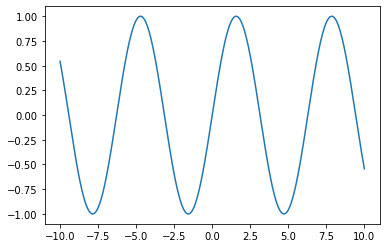

In [13]:
def get_data():
    x = np.linspace(-10,10,500)
    y = np.sin(x)
    return x, y

X,y = get_data()

plt.plot(X,y);

/home/tri-huynh/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tri-huynh/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Scores: [0.0026536269244392314, 0.002447166690883161, 0.00263423457846056, 0.002111374977979381, 0.0023035446252830517]
Root Mean Square Error: 0.002


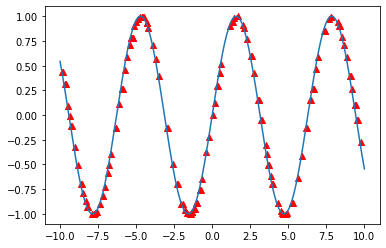

In [21]:
n_folds = 5
max_depth = 20  # maximum depth of tree
min_size = 2  # minimum size of 1 group

# Draw the predictions on the real data
x_train, x_test, y_train, y_test = train_test_split_manual(X,y,test_size=0.3)
predictions = decision_tree_regressor(list(zip(x_train, y_train)), \
                                      list(zip(x_test, y_test)), max_depth, min_size, criteria='mae')
plt.scatter(x_test,predictions,c='r', marker='^')
plt.plot(X,y);

# evaluate algorithm
scores = evaluate_algorithm(
    list(zip(X,y)), decision_tree_regressor, n_folds, max_depth, min_size, 'std')
print('Scores: %s' % scores)
print('Root Mean Square Error: %.3f' % (sum(scores)/float(len(scores))))

/home/tri-huynh/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tri-huynh/miniconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Scores: [0.02909884242697881, 0.037258822511645265, 0.03813850455952287, 0.029034202672610154, 0.03650837920031799]
Root Mean Square Error: 0.034


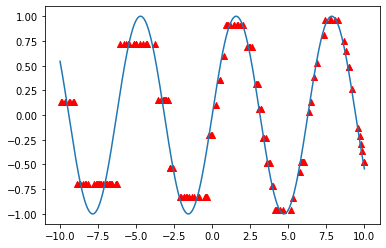

In [30]:
max_depth = 5  # maximum depth of tree
min_size = 1# minimum size of 1 group

# Draw the predictions on the real data
x_train, x_test, y_train, y_test = train_test_split_manual(X,y,test_size=0.3)
predictions = decision_tree_regressor(list(zip(x_train, y_train)), \
                                      list(zip(x_test, y_test)), max_depth, min_size, criteria='mae')
plt.scatter(x_test,predictions,c='r', marker='^')
plt.plot(X,y);

# evaluate algorithm
scores = evaluate_algorithm(
    list(zip(X,y)), decision_tree_regressor, n_folds, max_depth, min_size, 'std')
print('Scores: %s' % scores)
print('Root Mean Square Error: %.3f' % (sum(scores)/float(len(scores))))

## Conclusion

Version 0.1:
* RMSE:
    - 0.017 data/BankNote_Authentication.csv (**std**)
    - 0.018 data/BankNote_Authentication.csv (**mae**)
    - 0.232 data/sonar.csv (**std**)
    - 0.275 data/sonar.csv (**mae**)
    - 0.002 sine data (**max_depth** = 20, **std**)
    - 0.031 sine data (**max_depth** = 3, **std**)

`Note`: The idea of decision tree regressor is similar to that of decision tree classifier. The small change in code is that instead of use **entropy/gini_index** to find the best split in classifier version, this one use **std/mae**.

## Refs
https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

ZWMiller /machine_learning_from_scratch has a large library about "ML from scratch". This is one of his notebook about decision tree regressor:

https://github.com/ZWMiller/machine_learning_from_scratch/blob/master/notebooks/regressors/decision_tree_regressor.ipynb